In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

In [3]:
## Step 1: Load data and regimes
start_date = '2020-01-01'
end_date = '2024-01-01'

# Load data
tickers = ['SPY', 'EEM', 'GLD']
etf_raw = yf.download(tickers, start=start_date, end=end_date, progress=False)
etf_data = etf_raw['Close']

vix_raw = yf.download('^VIX', start=start_date, end=end_date, progress=False)
vix_data = vix_raw['Close']

dxy_raw = yf.download('DX-Y.NYB', start=start_date, end=end_date, progress=False)
dxy_data = dxy_raw['Close']

# Combine data
df = pd.DataFrame(index=etf_data.index)
df['SPY'] = etf_data['SPY']
df['EEM'] = etf_data['EEM'] 
df['GLD'] = etf_data['GLD']
df['VIX'] = vix_data.values
df['DXY'] = dxy_data.values

# Calculate returns and features
for asset in ['SPY', 'EEM', 'GLD', 'DXY']:
    df[f'{asset}_return'] = df[asset].pct_change()

df['DXY_50d_ROC'] = df['DXY'].pct_change(periods=50)

# Calculate VIX thresholds
vix_25th = df['VIX'].quantile(0.25)
vix_75th = df['VIX'].quantile(0.75)

# Apply regime classification
def classify_regime(row):
    vix = row['VIX']
    dxy_roc = row['DXY_50d_ROC']
    
    if pd.isna(vix) or pd.isna(dxy_roc):
        return 'Missing Data'
    
    if vix > vix_75th and dxy_roc > 0:
        return 'Risk-Off Dollar Strength'
    elif vix < vix_25th and dxy_roc > 0:
        return 'Pro-Growth Dollar Strength'
    elif dxy_roc < 0:
        return 'Dollar Weakness'
    else:
        return 'Neutral/Sideways'

df['Regime'] = df.apply(classify_regime, axis=1)

print(f"Regime distribution:")
print(df['Regime'].value_counts())

Regime distribution:
Regime
Dollar Weakness               394
Neutral/Sideways              266
Risk-Off Dollar Strength      168
Pro-Growth Dollar Strength    128
Missing Data                   50
Name: count, dtype: int64


In [4]:
## Step 2: Calculate performance statistics by regime
def calculate_performance_stats(returns, name="Asset"):
    """Calculate comprehensive performance statistics for a return series"""
   
    returns_clean = returns.dropna()
    
    if len(returns_clean) == 0:
        return {
            'count': 0,
            'mean_daily': np.nan,
            'std_daily': np.nan,
            'annualized_return': np.nan,
            'annualized_vol': np.nan,
            'sharpe_ratio': np.nan,
            'max_daily': np.nan,
            'min_daily': np.nan,
            'positive_days_pct': np.nan
        }
    
    mean_daily = returns_clean.mean()
    std_daily = returns_clean.std()
    
    # Annualized metrics (assuming 252 trading days)
    annualized_return = mean_daily * 252
    annualized_vol = std_daily * np.sqrt(252)
    
    # Sharpe ratio (assuming 0% risk-free rate)
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else np.nan
    
    # Additional metrics
    max_daily = returns_clean.max()
    min_daily = returns_clean.min()
    positive_days_pct = (returns_clean > 0).mean() * 100
    
    return {
        'count': len(returns_clean),
        'mean_daily': mean_daily,
        'std_daily': std_daily,
        'annualized_return': annualized_return,
        'annualized_vol': annualized_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_daily': max_daily,
        'min_daily': min_daily,
        'positive_days_pct': positive_days_pct
    }

# Calculate stats for each asset in each regime
assets = ['SPY', 'EEM', 'GLD']
regimes = ['Risk-Off Dollar Strength', 'Pro-Growth Dollar Strength', 'Dollar Weakness', 'Neutral/Sideways']

# Filter out missing data
analysis_df = df[df['Regime'] != 'Missing Data'].copy()

performance_results = {}
for asset in assets:
    performance_results[asset] = {}
    for regime in regimes:
        regime_data = analysis_df[analysis_df['Regime'] == regime]
        if len(regime_data) > 0:
            stats_dict = calculate_performance_stats(regime_data[f'{asset}_return'], f"{asset}_{regime}")
            performance_results[asset][regime] = stats_dict
        else:
            performance_results[asset][regime] = calculate_performance_stats(pd.Series([]), f"{asset}_{regime}")

In [5]:
## Step 3: Create summary tables
def create_performance_table(asset):
    """Create a formatted performance table for an asset"""
    data = []
    for regime in regimes:
        stats = performance_results[asset][regime]
        data.append({
            'Regime': regime,
            'Days': stats['count'],
            'Ann. Return (%)': stats['annualized_return'] * 100,
            'Ann. Vol (%)': stats['annualized_vol'] * 100,
            'Sharpe Ratio': stats['sharpe_ratio'],
            'Positive Days (%)': stats['positive_days_pct'],
            'Max Daily (%)': stats['max_daily'] * 100,
            'Min Daily (%)': stats['min_daily'] * 100
        })
    
    return pd.DataFrame(data)

# Print performance tables
for asset in assets:
    table = create_performance_table(asset)
    print(table.round(2))

                       Regime  Days  Ann. Return (%)  Ann. Vol (%)  \
0    Risk-Off Dollar Strength   168           -22.13         36.14   
1  Pro-Growth Dollar Strength   128            66.69          8.98   
2             Dollar Weakness   394            28.06         16.63   
3            Neutral/Sideways   266             7.93         16.80   

   Sharpe Ratio  Positive Days (%)  Max Daily (%)  Min Daily (%)  
0         -0.61              43.45           9.06         -10.94  
1          7.43              72.66           1.92          -1.39  
2          1.69              56.09           5.50          -5.76  
3          0.47              48.50           3.05          -3.38  
                       Regime  Days  Ann. Return (%)  Ann. Vol (%)  \
0    Risk-Off Dollar Strength   168           -48.94         36.96   
1  Pro-Growth Dollar Strength   128            34.76         13.83   
2             Dollar Weakness   394            35.06         18.72   
3            Neutral/Sideways   26

In [6]:
## Step 4: Statistical significance testing

def perform_anova_test(asset):
    """Perform ANOVA test to check if returns differ significantly across regimes"""
    groups = []
    regime_names = []
    
    for regime in regimes:
        regime_data = analysis_df[analysis_df['Regime'] == regime]
        if len(regime_data) > 5:  # Need minimum observations
            returns = regime_data[f'{asset}_return'].dropna()
            if len(returns) > 0:
                groups.append(returns)
                regime_names.append(regime)
    
    if len(groups) >= 2:
        f_stat, p_value = stats.f_oneway(*groups)
        return f_stat, p_value, regime_names
    else:
        return np.nan, np.nan, regime_names

for asset in assets:
    f_stat, p_value, tested_regimes = perform_anova_test(asset)
    print(f"{asset}: F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print(f"  Significant differences across regimes (p < 0.05)")
    else:
        print(f"  No significant differences across regimes (p >= 0.05)")

SPY: F-statistic = 1.9575, p-value = 0.1188
  No significant differences across regimes (p >= 0.05)
EEM: F-statistic = 2.6619, p-value = 0.0469
  Significant differences across regimes (p < 0.05)
GLD: F-statistic = 0.4424, p-value = 0.7227
  No significant differences across regimes (p >= 0.05)


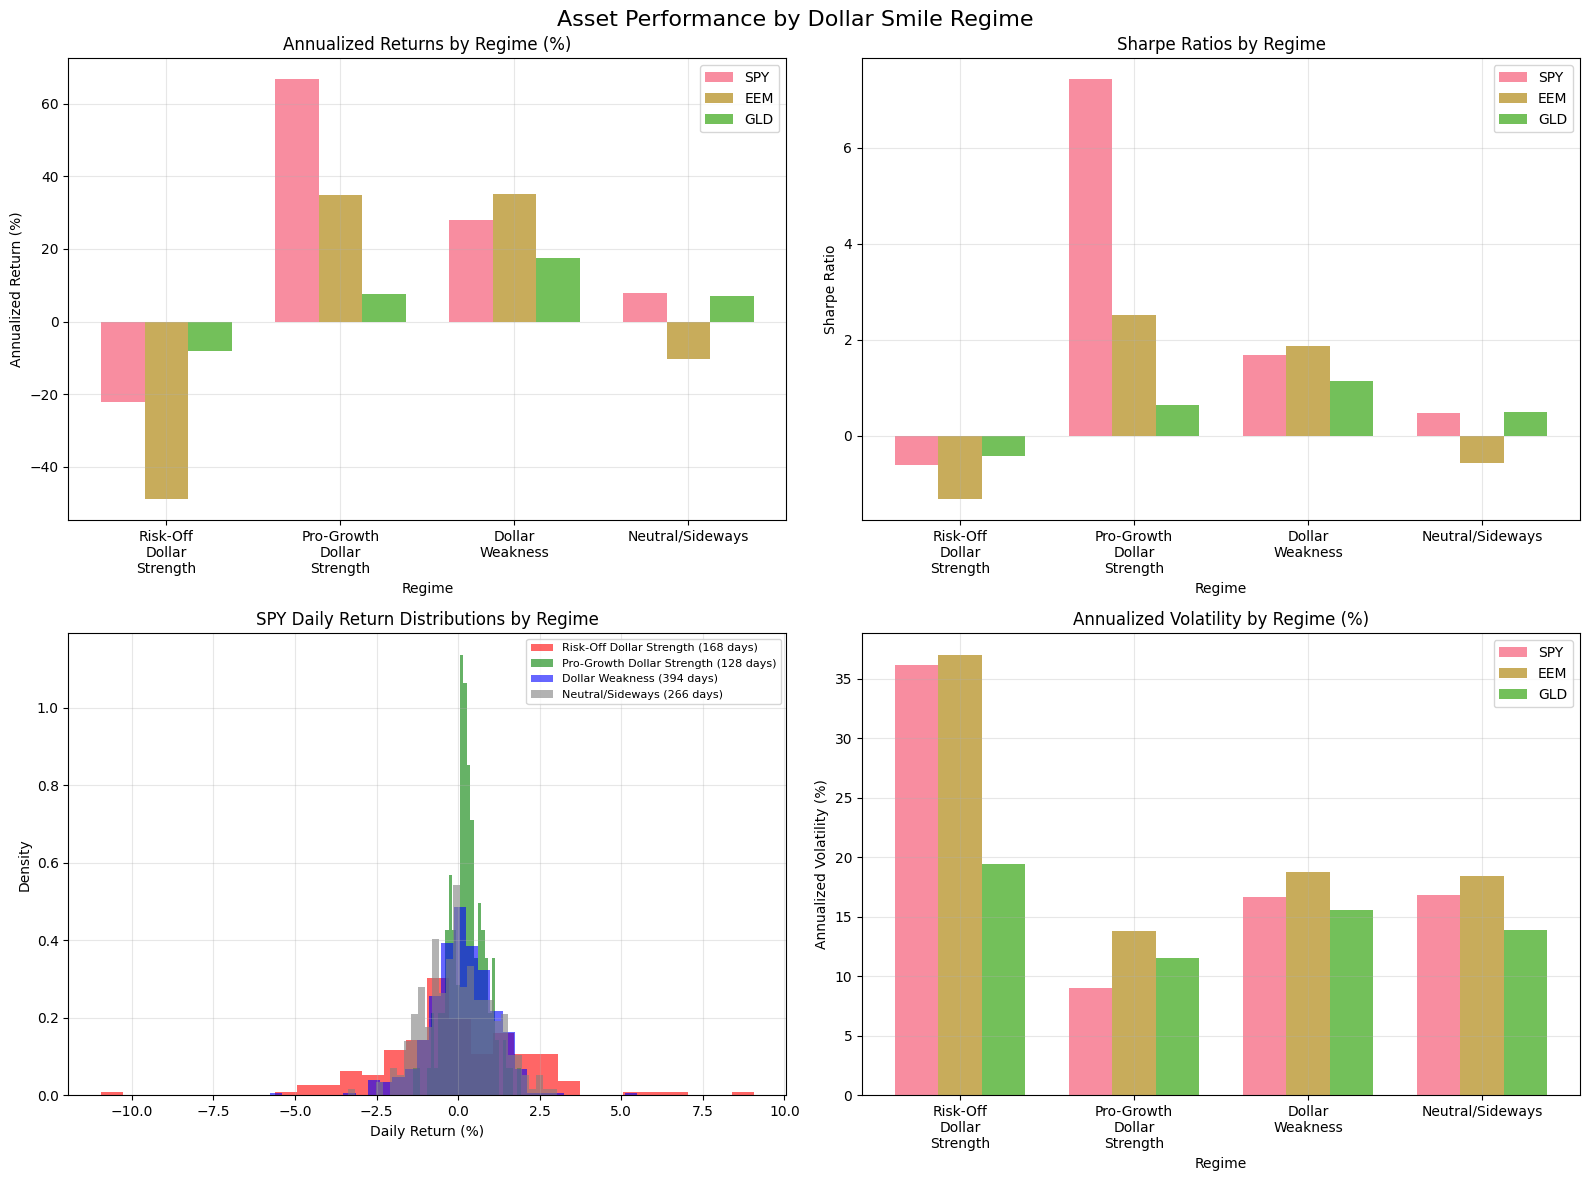

In [7]:
## Step 5: Visualization of performance by regime
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Asset Performance by Dollar Smile Regime', fontsize=16)

# Color scheme for regimes
regime_colors = {
    'Risk-Off Dollar Strength': 'red',
    'Pro-Growth Dollar Strength': 'green',
    'Dollar Weakness': 'blue',
    'Neutral/Sideways': 'gray'
}

# Plot 1: Annualized Returns
ax = axes[0, 0]
for i, asset in enumerate(assets):
    returns = [performance_results[asset][regime]['annualized_return'] * 100 for regime in regimes]
    x_pos = np.arange(len(regimes)) + i * 0.25
    ax.bar(x_pos, returns, width=0.25, label=asset, alpha=0.8)

ax.set_title('Annualized Returns by Regime (%)')
ax.set_xlabel('Regime')
ax.set_ylabel('Annualized Return (%)')
ax.set_xticks(np.arange(len(regimes)) + 0.25)
ax.set_xticklabels([r.replace(' ', '\n') for r in regimes], rotation=0, ha='center')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Sharpe Ratios
ax = axes[0, 1]
for i, asset in enumerate(assets):
    sharpes = [performance_results[asset][regime]['sharpe_ratio'] for regime in regimes]
    x_pos = np.arange(len(regimes)) + i * 0.25
    ax.bar(x_pos, sharpes, width=0.25, label=asset, alpha=0.8)

ax.set_title('Sharpe Ratios by Regime')
ax.set_xlabel('Regime')
ax.set_ylabel('Sharpe Ratio')
ax.set_xticks(np.arange(len(regimes)) + 0.25)
ax.set_xticklabels([r.replace(' ', '\n') for r in regimes], rotation=0, ha='center')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Return distributions by regime for SPY
ax = axes[1, 0]
for regime in regimes:
    regime_data = analysis_df[analysis_df['Regime'] == regime]
    if len(regime_data) > 10:
        returns = regime_data['SPY_return'].dropna() * 100
        ax.hist(returns, bins=30, alpha=0.6, label=f'{regime} ({len(returns)} days)', 
                color=regime_colors[regime], density=True)

ax.set_title('SPY Daily Return Distributions by Regime')
ax.set_xlabel('Daily Return (%)')
ax.set_ylabel('Density')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 4: Volatility comparison
ax = axes[1, 1]
for i, asset in enumerate(assets):
    vols = [performance_results[asset][regime]['annualized_vol'] * 100 for regime in regimes]
    x_pos = np.arange(len(regimes)) + i * 0.25
    ax.bar(x_pos, vols, width=0.25, label=asset, alpha=0.8)

ax.set_title('Annualized Volatility by Regime (%)')
ax.set_xlabel('Regime')
ax.set_ylabel('Annualized Volatility (%)')
ax.set_xticks(np.arange(len(regimes)) + 0.25)
ax.set_xticklabels([r.replace(' ', '\n') for r in regimes], rotation=0, ha='center')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
## Step 6: Dollar Smile Theory Validation

print("Testing Dollar Smile predictions:")

# 1. Risk-Off periods: USD strength hurts EM, mixed for US equities, may help gold
spy_risk_off = performance_results['SPY']['Risk-Off Dollar Strength']['annualized_return']
eem_risk_off = performance_results['EEM']['Risk-Off Dollar Strength']['annualized_return']
gld_risk_off = performance_results['GLD']['Risk-Off Dollar Strength']['annualized_return']

print(f"\n1. Risk-Off Dollar Strength periods:")
print(f"   SPY: {spy_risk_off*100:.1f}% annualized")
print(f"   EEM: {eem_risk_off*100:.1f}% annualized") 
print(f"   GLD: {gld_risk_off*100:.1f}% annualized")
print(f"   Theory check: EEM should underperform SPY: {'✅' if eem_risk_off < spy_risk_off else '❌'}")

# 2. Pro-Growth periods: USD strength from economic strength, good for US assets
spy_pro_growth = performance_results['SPY']['Pro-Growth Dollar Strength']['annualized_return']
eem_pro_growth = performance_results['EEM']['Pro-Growth Dollar Strength']['annualized_return']

print(f"\n2. Pro-Growth Dollar Strength periods:")
print(f"   SPY: {spy_pro_growth*100:.1f}% annualized")
print(f"   EEM: {eem_pro_growth*100:.1f}% annualized")
print(f"   Theory check: SPY should do well in pro-growth periods: {'✅' if spy_pro_growth > 0.1 else '❌'}")

# 3. Dollar Weakness: Should help EM and commodities
spy_weak = performance_results['SPY']['Dollar Weakness']['annualized_return']
eem_weak = performance_results['EEM']['Dollar Weakness']['annualized_return']
gld_weak = performance_results['GLD']['Dollar Weakness']['annualized_return']

print(f"\n3. Dollar Weakness periods:")
print(f"   SPY: {spy_weak*100:.1f}% annualized")
print(f"   EEM: {eem_weak*100:.1f}% annualized")
print(f"   GLD: {gld_weak*100:.1f}% annualized")
print(f"   Theory check: EEM should benefit from dollar weakness: {'✅' if eem_weak > spy_weak else '❌'}")

print(f"✅ Performance calculated for all assets across regimes")
print(f"✅ Statistical significance tested")
print(f"✅ Dollar Smile theory predictions evaluated")

Testing Dollar Smile predictions:

1. Risk-Off Dollar Strength periods:
   SPY: -22.1% annualized
   EEM: -48.9% annualized
   GLD: -8.0% annualized
   Theory check: EEM should underperform SPY: ✅

2. Pro-Growth Dollar Strength periods:
   SPY: 66.7% annualized
   EEM: 34.8% annualized
   Theory check: SPY should do well in pro-growth periods: ✅

3. Dollar Weakness periods:
   SPY: 28.1% annualized
   EEM: 35.1% annualized
   GLD: 17.6% annualized
   Theory check: EEM should benefit from dollar weakness: ✅
✅ Performance calculated for all assets across regimes
✅ Statistical significance tested
✅ Dollar Smile theory predictions evaluated
